<center> <h1>Team name: Turquoise</h1> </center>

<img src="images/k.jpg" alt="drawing" width="800"/>


- Members:
	- **Rabia Yasa Kostas**
	- **Kahraman Kostas**

The team presenter: **Kahraman Kostas**

<center> <h1>TASK 2</h1> </center> 

**NOTE: it is sufficient to run all cells from top to bottom, taking into account the bolded notes.**

The steps in task 2 can be summarized as follows:

- The inputs are read and a graphic file is created from them.
- The graphic file is saved as an adjacency list.
- The adjacency list is vectorized using `Node2vec`.
- IDs are grouped by the k-means algorithm according to the vectors.
- The results file (`TASK2-Mysubmission.csv`) is prepared according to the trajectory of IDs .

These steps are illustrated in the image below.

<img src="images/kmeans.png" alt="TASK-2 Steps" width="1000"/>

## 2.1 Installing modules
We used [Python 3.6.5](https://www.python.org/downloads/) to create the application file. We included some additional modules that were not included in the example file given at the start of the competition. These modules can be listed as:


| Molules | Task |
| ------ | ------ |
|[ scikit-learn ](https://scikit-learn.org/stable/install.html)| Machine Learning & Data Preparation|
|[ node2vec  ](https://snap.stanford.edu/node2vec/)| Scalable Feature Learning for Networks|
|[ numpy ](https://numpy.org/) |Mathematical Operations|



We started with the installation of these modules as the first step.

In [1]:
## 2.1 Installing modules
!pip install node2vec
!pip install scikit-learn
!pip install numpy 

## 2.2  Setting Random Seeds
In this step, we fixed the related random seed to be used in order to obtain repeatable results. In this way, we have provided a deterministic path where we get the same result in every run. However, according to our observations, the results obtained on different computers may differ slightly (±1%)

In [2]:
## 2.2  Setting Random Seeds
seed_value=0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

## 2.3 Loading the data  
In this section, the files given for the test data are loaded.
- `wifi`  variable takes IDs and weights from the  `task2_test_estimated_wifi_distances.csv`.
- `steps`  variable takes IDs and weights from file `task2_test_steps.csv`.
- `elevs`  variable takes IDs from file  `task2_test_elevations.csv`.
- `fp_lookup`  variable gets  IDs and trajectories from the  `task2_test_lookup.json` file.


We did not prefer the method of recalculating the estimated distances given in wifi with the model we obtained in Task1, because the results we obtained from this process did not make a significant difference. That's why we didn't use the `task2_test_fingerprints.json` file in our ultimate work.




**Please make sure there are `task2_test_estimated_wifi_distances.csv`, `task2_test_steps.csv`, `task2_test_elevations.csv`, `task2_test_lookup.json`  files in the `task2_for_participants/test` folder!**

In [1]:
# unzip required files
import zipfile
with zipfile.ZipFile("task2_for_participants.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [3]:
## 2.3 Loading the data  
import os
import json
import csv
import networkx as nx
from tqdm import tqdm

path_to_data = "task2_for_participants/test"

with open(os.path.join(path_to_data,"task2_test_estimated_wifi_distances.csv")) as f:
    wifi = []
    reader = csv.DictReader(f)
    for line in tqdm(reader):
        wifi.append([line['id1'],line['id2'],float(line['estimated_distance'])])
        
with open(os.path.join(path_to_data,"task2_test_elevations.csv")) as f:
    elevs = []
    reader = csv.DictReader(f)
    for line in tqdm(reader):
        elevs.append([line['id1'],line['id2']])        

with open(os.path.join(path_to_data,"task2_test_steps.csv")) as f:
    steps = []
    reader = csv.DictReader(f)
    for line in tqdm(reader):
        steps.append([line['id1'],line['id2'],float(line['displacement'])]) 
        
fp_lookup_path = os.path.join(path_to_data,"task2_test_lookup.json")

with open(fp_lookup_path) as f:
    fp_lookup = json.load(f)

3773297it [00:28, 130148.06it/s]
2767it [00:00, 32477.68it/s]
139537it [00:01, 84595.84it/s]


## 2.3 Generating the Trajectory  graph. 
We take the average distance as the weight when creating the Trajectory graph. We used the example given for Task 2 (`Task2-IPS-Challenge-2021.ipynb`) for this process. We saved the resulting graph (`B`) as an adjacency list in the directory (as `my.adjlist`).

In [4]:
## 2.3 Generating the Trajectory  graph. 
B = nx.Graph()

# Get all the trajectory ids from the lookup
valid_nodes = set(fp_lookup.values())

for node in valid_nodes:
    B.add_node(node)

# Either add an edge or append the distance to the edge data
for id1,id2,dist in tqdm(wifi):
    if not B.has_edge(fp_lookup[str(id1)], fp_lookup[str(id2)]):
        
        B.add_edge(fp_lookup[str(id1)], 
                   fp_lookup[str(id2)], 
                   ty = "w", weight=[dist])
    else:
        B[fp_lookup[str(id1)]][fp_lookup[str(id2)]]['weight'].append(dist)
        
# Compute the mean edge weight
for edge in B.edges(data=True):
    B[edge[0]][edge[1]]['weight'] = sum(B[edge[0]][edge[1]]['weight'])/len(B[edge[0]][edge[1]]['weight'])
        
# If you have made a wifi connection between trajectories with an elev, delete the edge
for id1,id2 in tqdm(elevs):
    if B.has_edge(fp_lookup[str(id1)], fp_lookup[str(id2)]):
        B.remove_edge(fp_lookup[str(id1)], 
                      fp_lookup[str(id2)])

nx.write_adjlist(B, "my.adjlist")

100%|██████████████████████████████████████████████████████████████████████████| 2767/2767 [00:00<00:00, 177144.76it/s]


## 2.4 Converting nodes to vectors
Before giving the adjacency list as input to the machine learning algorithms, we convert the nodes to vector. In our work we used Node2vec as a graph embedding algorithm methodology proposed by Grover&Leskovec in 2016 \[1\]. Node2vec is a semi-supervised algorithm for feature learning of the nodes in the network. Node2vec is created based on the skip-gram technique, which is an NLP approach motivated on Distributional Structure concept.According to idea, if different words used in similar contexts they probably have a similar meaning and there is an obvious relationship between them. Skip-gram technique uses center word(input) to predict neighbours(output) while computing the probabilities of surroundings based on a given window size (contiguous sequence of items before of after the center), in other words N-grams. Unlike the NLP approach, Node2vec system is not fed with words which have a linear structure, but nodes and edges, which have a distributed graphical structure. This multidimensional structure makes embeddings complex and computationally expensive, but Node2vec uses negative sampling with optimizing stochastic gradient descent (SGD) to deal with it. In addition to this, The random walk approach is used to detect sample neighboring nodes of the source node in a nonlinear structure. 

In our study, we first performed the vector representation of node relationships in low-dimensional space by modeling with node2vec from given distance of two nodes (weights). Then we used the output of Node2vec (graph embeddings), which has vectors of nodes, to feed traditional K-means clustering algorithm.

The parameters we use in Nod2vec can be listed as follows:

| Hyperparameter | Value |
| ------ | ------ |
|dimensions|32|
|walk_length|15|
|num_walks|100|
|workers|1|
|seed|0|
|window|10|
|min_count|1|
|batch_words|4|

The Node2vec model takes the adjacency list as input and outputs a 32-size vector. In this part, the node.py file is created and run in the `Jupyter Notebook`. There are two reasons why it is preferable to run externally rather than in a Jupyter notebook cell.
- It allows fixing the random seed of the node2vec module. Thus, it ensures repeatability by providing the same result in different runs.
- `Node2vec` is a very computationally expensive method, RAM overflow error is quite possible if run inside Jupyter notebook. Creating and running `Node2vec` model outside avoids this error.

The cell below creates the file named node.py. This file creates the node2vec model. This model takes the the adjacency list (`my.adjlist`) as input and creates a 32-dimensional vector file as output (`vectors.emb`).

**Important! The code below should be run in Linux distributions (Tested in Google colab and Ubuntu).**

In [5]:
# 2.4 Converting nodes to vectors
# A folder named tmp is created. This folder is essential for the node2vec model to use less RAM.
try:
    if not os.path.exists("tmp"):
        os.makedirs("tmp")
except OSError:
    print ("The folder could not be created!\n Please manually create the \"tmp\" folder in the directory")


node="""

# importing related modules

from node2vec import Node2Vec
import networkx as nx

#importing  adjacency list file as B
B = nx.read_adjlist("my.adjlist")

seed_value=0


# Specifying the input and hyperparameters of the node2vec model
node2vec = Node2Vec(B, dimensions=32, walk_length=15, num_walks=100, workers=1,seed=seed_value,temp_folder = './tmp')  

#Assigning/specifying random seeds

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)


# creation of the model

model = node2vec.fit(window=10, min_count=1, batch_words=4,seed=seed_value)   


# saving the output vector

model.wv.save_word2vec_format("vectors.emb")

# save the model
model.save("vectorMODEL")

"""
f = open("node.py", "w")
f.write(node)
f.close()


!PYTHONHASHSEED=0 python3 node.py 


'PYTHONHASHSEED' is not recognized as an internal or external command,
operable program or batch file.


## 2.4 Reshaping data
After our vector file is created, we read this file (`vectors.emb`). This file consists of 33 columns. The first column is the node number (IDs), and remain are vector values. By sorting the entire file by the first column, we return the nodes to their original order. Then we delete this ID column, which we will no longer use. So, we give the final shape of our data. Our data is ready to be used in machine learning applications.

In [5]:
# 2.4 Reshaping data
vec = np.loadtxt("vectors.emb", skiprows=1)
print("shape of vector file: ",vec.shape)
print(vec)
vec=vec[vec[:,0].argsort()]; 
vec=vec[0:vec.shape[0],1:vec.shape[1]]

shape of vector file:  (11162, 33)
[[ 9.1200000e+03  3.9031842e-01 -4.7147268e-01 ... -5.7490986e-02
   1.3059708e-01 -5.4280665e-02]
 [ 6.5320000e+03 -3.5591956e-02 -9.8558587e-01 ... -2.7217887e-02
   5.6435770e-01 -5.7787680e-01]
 [ 5.6580000e+03  3.5879680e-01 -4.7564098e-01 ... -9.7607370e-02
   1.5506668e-01  1.1333219e-01]
 ...
 [ 2.7950000e+03  1.1724627e-02  1.0272172e-02 ... -4.5596390e-04
  -1.1507459e-02 -7.6738600e-04]
 [ 4.3380000e+03  1.2865483e-02  1.2103912e-02 ...  1.6619096e-03
   1.3672550e-02  1.4605848e-02]
 [ 1.1770000e+03 -1.3707868e-03  1.5238028e-02 ... -5.9994194e-04
  -1.2986251e-02  1.3706315e-03]]


## 2.5 Determine the number of clusters

Task-2 is a clustering problem. The premise that we need to decide when solving this problem is how many clusters we should divide into. For this, we tried different cluster numbers and compared the scores we got. The graph below shows the comparison of the number of clusters and the score obtained. As can be seen from this graph, the number of clusters increased continuously between 5 and 21, with some exception fluctuations, and stabilized after 21. For this reason, we focused on the number of clusters between 21 and 23 in our study.

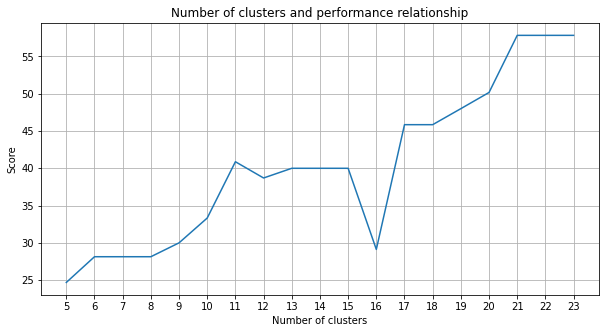

In [6]:
# 2.5 Determine the number of clusters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
agglom=[24.69,28.14,28.14,28.14,30,33.33,40.88,38.70,40,40,40,29.12,45.85,45.85,48.00,50.17,57.83,57.83,57.83]
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(range(5, 24), agglom)
matplotlib.pyplot.xticks(range(5, 24))
plt.title('Number of clusters and performance relationship')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

## 2.5  Best result

Among the unsupervised machine learning methods we tried (such as [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means),
[Agglomerative Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering),
[Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation),
[Mean Shift](https://scikit-learn.org/stable/modules/clustering.html#mean-shift),
[Spectral clustering](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering),
[DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan),
[OPTICS](https://scikit-learn.org/stable/modules/clustering.html#optics),
[BIRCH](https://scikit-learn.org/stable/modules/clustering.html#birch),
[Mini-Batch K-Means](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-k-means)), we achieved the best results using k-Means with 23 clusters.


K-means is a clustering algorithm is one of the basic and traditional unsupervised machine learning techniques which make assumptions to find homogeneous or natural groups of elements (clusters) using unlabelled data. Clusters are to set of points (nodes in our data) grouped together which share particular similarities. K-means needs the target number of centroids which refers to how many groups the data should be divided into. Algorithm starts with group of randomly assigned centroids then continue iterations to find the best positions of them. The algorithm assigns the points/nodes to the appointed centroids using in-cluster the sum of squares of the member of points, this is continue updating and relocating \[2\]. In our example the number of centroids reflects the number of floors. It should be noted that this does not provide information about the order of the floors.


Below, k-Means application has been made for 23 clusters.

In [7]:
# 2.5  Best result
from sklearn import cluster
import time

ML_results = []
k_clusters = 23
algorithms = {}
algorithms['KMeans'] =cluster.KMeans(n_clusters=k_clusters,random_state=10)
second=time.time()
for model in algorithms.values():
    model.fit(vec)
    ML_results=list(model.labels_)
    print(model,time.time()-second)

KMeans(n_clusters=23, random_state=10) 1.1391944885253906


## 2.6 Submission 
The output of the machine learning algorithm determines which cluster the fingerprints belong to. But what is required of us is to cluster the trajectories. Therefore, these fingerprints are converted to their trajectory counterparts using the `fp_lookup` variable. This output is processed into the `TASK2-Mysubmission.csv` file.

In [ ]:
## 2.6 Submission 
result={}
for ii,i in enumerate(set(fp_lookup.values())):
    result[i]=ML_results[ii]
        
    
ters={}
for i in result:
    if result[i] not in ters:
        ters[result[i]]=[]
        ters[result[i]].append(i)
    else:
        ters[result[i]].append(i)
        
        
        
final_results=[]
for i in ters:
    final_results.append(ters[i])
    
    
name="TASK2-Mysubmission.csv"    
with open(name, "w", newline='') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(final_results)
print(name, "file is ready!")

-----------------------

# References

\[1\] A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016.

\[2\] Jin X., Han J. (2011) K-Means Clustering. In: Sammut C., Webb G.I. (eds) Encyclopedia of Machine Learning. Springer, Boston, MA. https://doi.org/10.1007/978-0-387-30164-8_425